<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw11/Homework11_selfsupervised2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 361, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 361 (delta 112), reused 90 (delta 65), pack-reused 163
Receiving objects: 100% (361/361), 55.77 MiB | 37.35 MiB/s, done.
Resolving deltas: 100% (169/169), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=26856 sha256=7c83994a554bfab9231e5ce799bc61ae249f3ee49a230bb19d66b93a8fc85afd
  Stored in directory: /tmp/pip-ephem-wheel-cache-_mvebtpt/wheels/55/59/29/0fb1c6356521

In [7]:
from dul_2021.utils.hw11_utils import *

# Question 1. BYOL

Here we will implement [BYOL](https://arxiv.org/abs/2006.07733).

* You can combine view, representation, and projection into one network. You can use same architechure as in practice. 

* Use BatchNorm

* As predictor use few linear layers

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* τ = 0.99 (target update coefficient)
* lr = 1e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [8]:
import numpy as np
import torch
import torch.nn.functional as F

from torchvision import transforms
from torch import nn
from copy import deepcopy

from tqdm import tqdm


class Net(nn.Module):
    def __init__(self, in_dim=3, out_dim=128, hid_dim_full=128):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_dim, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(32)
        self.bn6 = nn.BatchNorm2d(4)

        self.conv_to_fc = 4 * 6 * 6
        self.fc1 = nn.Linear(self.conv_to_fc, hid_dim_full)
        self.fc2 = nn.Linear(hid_dim_full, int(hid_dim_full // 2))

        self.features = nn.Linear(int(hid_dim_full // 2), out_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))

        x = x.view(-1, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        features = self.features(x)

        return features


class BYOL(nn.Module):
    def __init__(self):
        super().__init__()
        self.student = Net(1, 128)

        self.teacher = deepcopy(self.student)
        self.teacher.requires_grad_(False)

        self.transforms = nn.Sequential(
            *[
                transforms.RandomHorizontalFlip(),
                transforms.RandomResizedCrop(size=24),
                transforms.GaussianBlur(kernel_size=9),
            ]
        )

        self.inference_transforms = transforms.Resize(24)

    @property
    def device(self):
        return next(self.student.parameters()).device

    def __soft_update(self, src, tgt, eps=0.99):
        for src_p, tgt_p in zip(src, tgt):
            tgt_p.copy_(eps * tgt_p + (1 - eps) * src_p)

    def fit(self, data_loader, n_epochs=10, lr=1e-4, device="cpu"):
        self.to(device)
        losses = []
        opt = torch.optim.Adam(self.student.parameters(), lr=lr)
        for epoch in range(n_epochs):
            for batch in tqdm(data_loader):
                t1 = self.transforms(batch).to(device)
                t2 = self.transforms(batch).to(device)

                z1 = self.student(t1)
                z2 = self.teacher(t2)

                z1 = z1 / torch.norm(z1, dim=0)
                z2 = z2 / torch.norm(z2, dim=0)

                loss = F.mse_loss(z1, z2, reduction="none")
                loss = loss.sum(-1).mean()

                losses.append(loss.item())

                opt.zero_grad()
                loss.backward()
                opt.step()

        return np.array(losses)

    @torch.inference_mode()
    def encode(self, batch):
        batch = self.inference_transforms(batch)
        return self.student(batch.to(self.device))

In [44]:
def q1(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    torch.manual_seed(42)
    bs = 128
    lr = 1e-4
    n_epochs = 4
    device = "cuda"

    train_data = [im for (im, label) in train_data]

    data_loader = torch.utils.data.DataLoader(train_data, batch_size=bs)

    model = BYOL()
    losses = model.fit(data_loader, n_epochs, lr=lr, device=device)

    return losses, model.encode

100%|██████████| 469/469 [00:16<00:00, 28.29it/s]


mean classification accuracy=0.6110


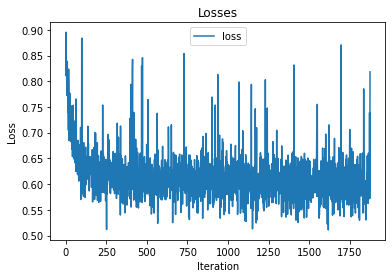

In [45]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q1_results(q1, True)

# Question 2. Barlow Twins

Here we will implement [barlow twins](https://arxiv.org/abs/2103.03230).

* You can use same architechure as in practice. 

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* λ = 0.01 
* lr = 5e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [16]:
class Net(nn.Module):
    def __init__(self, in_dim=3, out_dim=128, hid_dim_full=128):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_dim, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(32)
        self.bn6 = nn.BatchNorm2d(4)

        self.conv_to_fc = 4 * 7 * 7
        self.fc1 = nn.Linear(self.conv_to_fc, hid_dim_full)
        self.fc2 = nn.Linear(hid_dim_full, int(hid_dim_full // 2))

        self.features = nn.Linear(int(hid_dim_full // 2), out_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))

        x = x.reshape(-1, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        features = self.features(x)

        return features


class BarlowTwins(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = Net(3, 128)

        self.transforms = nn.Sequential(
            *[
                transforms.RandomHorizontalFlip(),
                transforms.RandomResizedCrop(size=28),
                transforms.GaussianBlur(kernel_size=9),
                transforms.RandomApply([
                    transforms.ColorJitter(brightness=0.5,
                                           contrast=0.5,
                                           saturation=0.5,
                                           hue=0.1)
                ], p=0.8),
                transforms.RandomGrayscale(p=0.2),
            ]
        )

        self.inference_transforms = transforms.Resize(28)

    @property
    def device(self):
        return next(self.model.parameters()).device

    def __corr_matrix(self, z1, z2):
        enum = torch.einsum("ab,ac->bc", z1, z2)
        denum = (z1 ** 2).sum(0).sqrt() * (z2 ** 2).sum(0).sqrt().reshape(-1, 1)
        corr_matrix = enum / denum / z1.shape[0]

        return corr_matrix

    def fit(self, data_loader, n_epochs=10, lr=1e-4, lm=0.01, device="cpu"):
        self.to(device)
        losses = []
        opt = torch.optim.Adam(self.model.parameters(), lr=lr)
        for epoch in range(n_epochs):
            for batch in tqdm(data_loader):
                t1 = self.transforms(batch).to(device)
                t2 = self.transforms(batch).to(device)

                z1 = self.model(t1)
                z2 = self.model(t2)

                z1 = (z1 - z1.mean(0)) / z1.std(0)
                z2 = (z2 - z2.mean(0)) / z2.std(0)

                corr_matrix = self.__corr_matrix(z1, z2)

                invariance = ((1 - corr_matrix.diag()) ** 2).sum()

                # zeroing diagonal elements
                corr_matrix.diagonal(dim1=-1, dim2=-2).zero_()

                redundancy_reduction = (corr_matrix ** 2).sum()

                loss = invariance + lm * redundancy_reduction

                losses.append(loss.item())

                opt.zero_grad()
                loss.backward()
                opt.step()

        return np.array(losses)

    @torch.inference_mode()
    def encode(self, batch):
        batch = self.inference_transforms(batch)
        return self.model(batch.to(self.device))

In [19]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    torch.manual_seed(42)
    bs = 256
    lr = 5e-4
    n_epochs = 20
    device = "cuda"

    train_data = [im for (im, label) in train_data]

    data_loader = torch.utils.data.DataLoader(train_data, batch_size=bs)

    model = BarlowTwins()
    losses = model.fit(data_loader, n_epochs, lr=lr, device=device)

    return losses, model.encode

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 196/196 [00:34<00:00,  5.64it/s]


mean classification accuracy=0.1639


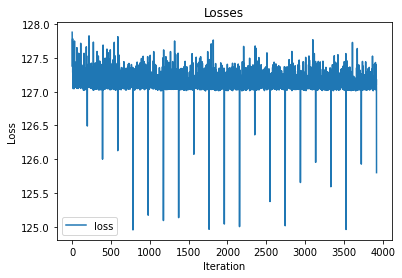

In [20]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q2_results(q2, True)

# Bonus. SwAV

Here we will implement [SwAV](https://arxiv.org/abs/2006.09882v5)

**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [ ]:
def b(train_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

In [ ]:
q2_results(b, True)